# Parameter inference

In [1]:
# install if not done yet
!pip install pyabc --quiet

Let's start by importing the necessary packages:

In [2]:
import pyabc

import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

## Problem definition

Our model is about as simple as it gets. We assume a Gaussian model $\mathcal{N}(\mu, 0.5^2)$ with a single parameter $\mu$ and fixed variance $0.5^2$.

In [3]:
def model(parameter):
    return {"data": parameter["mu"] + 0.5 * np.random.randn()}

In [4]:
prior = pyabc.Distribution(mu=pyabc.RV("uniform", 0, 5))

<div class="alert alert-warning">
Note: A common mistake is that the scipy uniform distribution takes arguments `lower_bound, width`, the second argument not being the upper bound. For example, `RV("uniform", 1, 5)` is uniform over the interval $[1,6]$. Check the `scipy.stats` package for details of the definition.
</div>

We also need to specify a distance function, measuring closeness of simulated and observed data.
We just take the absolute value of the difference here.

In [5]:
def distance(x, x0):
    return abs(x["data"] - x0["data"])

## ABC inference

In [6]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)

ABC.Sampler INFO: Parallelize sampling on 4 processes.


In [7]:
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = 2.5
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.History INFO: Start <ABCSMC id=1, start_time=2021-12-03 01:50:55>


Let's start the sampling now. We'll sample until the acceptance threshold epsilon drops below 0.1. We also specify that we want a maximum number of 10 populations.
So whatever is reached first, `minimum_epsilon` or `max_nr_populations`, will stop further sampling.

The acceptance thresholds are automatically calibrated and updated. This and further components such as proposal kernels and parallelization strategy (on Linux, per default multi-processing) can be modified via arguments to the ``ABCSMC` class, see the API documentation or further examples.

For the simple model we defined above, this should only take a couple of seconds:

In [8]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.30729591e+00.
ABC INFO: Accepted: 1000 / 1996 = 5.0100e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.49162964e-01.
ABC INFO: Accepted: 1000 / 2318 = 4.3141e-01, ESS: 9.3941e+02.
ABC INFO: t: 2, eps: 3.23197466e-01.
ABC INFO: Accepted: 1000 / 3379 = 2.9595e-01, ESS: 5.6505e+02.
ABC INFO: t: 3, eps: 1.61082773e-01.
ABC INFO: Accepted: 1000 / 6010 = 1.6639e-01, ESS: 6.8310e+02.
ABC INFO: t: 4, eps: 7.86792075e-02.
ABC INFO: Accepted: 1000 / 11690 = 8.5543e-02, ESS: 7.3940e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:15.742993, end_time=2021-12-03 01:51:11>


The `History` object returned by `ABCSMC.run` can be used to query the database.
This object is also available via `abc.History("sqlite:///" + db_path)`.

## Visualization and analysis of results

Now, we can visualize the obtained Bayesian posterior approximation.
The vertical line indicates the location of the observation, while the curves give the ABC posterior at different generations (usually, only the last one is of interest).
Given our model, we expect the mean to be close to the observed data, with some uncertainty. For more-dimensional parameter vectors, pyABC also offers `plot_kde_2d` and `plot_kde_matrix` plots.

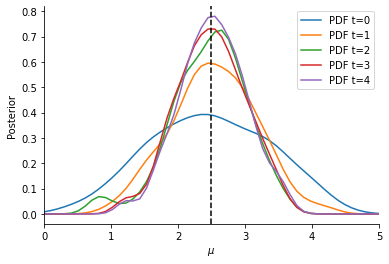

In [9]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=5,
        x="mu",
        xname="$\mu$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();

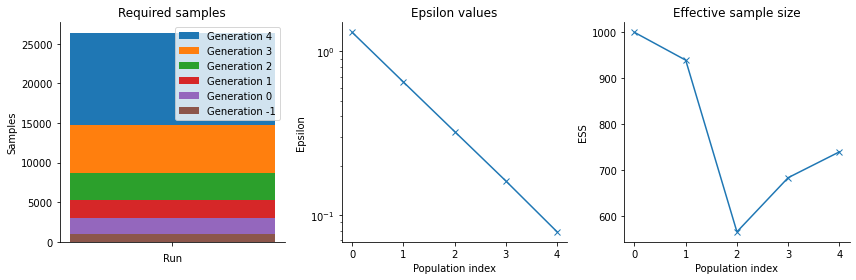

In [10]:
fig, arr_ax = plt.subplots(1, 3, figsize=(12, 4))

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[1])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[2])

fig.tight_layout()

That's it. Now you can go ahead and try more sophisticated models.